# Import Libraries and Load Data

In [1]:
# Import data handling libraries
import numpy as np 
import pandas as pd 
from sklearn import preprocessing, model_selection, metrics

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import modeling libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Import libraries used in hyperparameter tuning
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV



In [2]:
# Download the data and load it into pandas
url="https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df=pd.read_excel(url,header=1,index_col=0)

In [3]:
# Perform a quick visual inspection of the data
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Do some house keeping, and clean up the name of the response variable to be 
# consistent with the rest of the columns.
df.rename(columns={'default payment next month':'DEFAULT_NEXT_MONTH'},
          inplace=True)

In [5]:
# Do we have any rows with missing values?
num_incomplete_rows =  df.shape[0] - df.dropna().shape[0]
print('There are {} rows with missing values.'.format(num_incomplete_rows))

There are 0 rows with missing values.


# Data Inspection and Cleansing

## Categorical Data Inspection and Cleansing
Inspect the categorical variables, look for anomalies, and filter out bad data. We will look at basic descriptions of the data, as well generate histograms.


### Basic Categorical Features
Here let's examine the following features:

SEX

EDUCATION

MARIAGE

In [6]:
# Basic statistics of the three categorical columns:
df[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


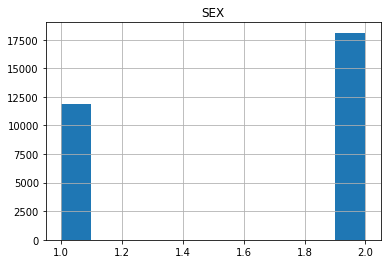

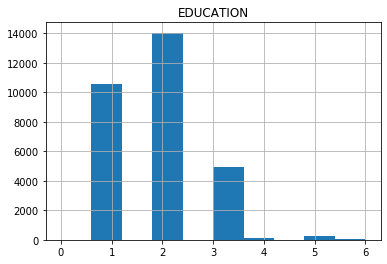

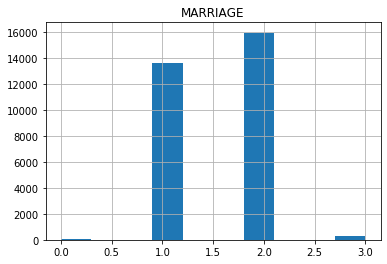

In [7]:
# Look at histograms of categorical features to see if everything checks out
_=df.hist('SEX')
_=df.hist('EDUCATION')
_=df.hist('MARRIAGE')

There appears to be no issue with the SEX column, but MARRIAGE and EDUCATION show discrepancies with the data description. Unfortunately, we will need to filter out these problem rows. 

**MARRIAGE** - MARRIAGE should only be 1, 2, or 3, but has values that are 0, which is undocumented. Rows with these values will be removed.

**EDUCATION** - EDUCATION should only be 1, 2, 3, or 4, but has values of 5 and 6, which are undocumented. Rows with these values will be removed.

In [8]:
# Drop the rows with bad data
print('Number of rows before filtering:\t{}'.format(len(df.index)))
df = df[df.EDUCATION.isin([1,2,3,4])]
df = df[df.MARRIAGE.isin([1,2,3])]
print('Number of rows after filtering: \t{}'.format(len(df.index)))

Number of rows before filtering:	30000
Number of rows after filtering: 	29601


### Payment Categorical Features
Let's examine the payment categorical features. Right away, these fields don't seem to comply with the given data set description. Some simple descriptors can help us determine if these features are worth incorporating in our analysis, or if we're better off engineering our own features that are similar.

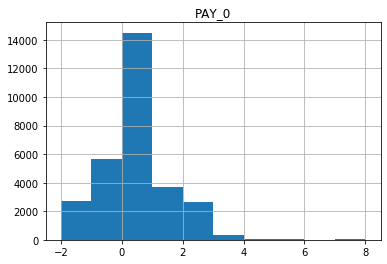

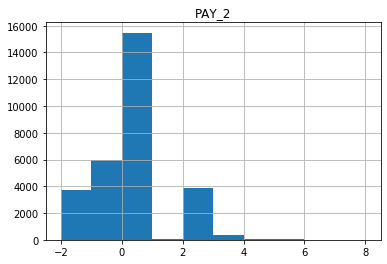

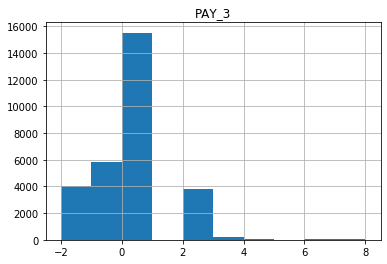

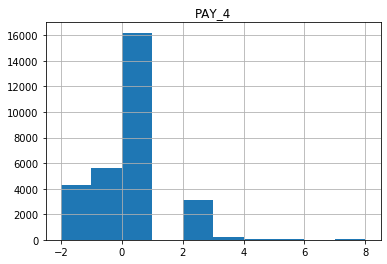

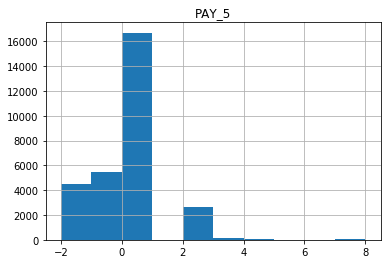

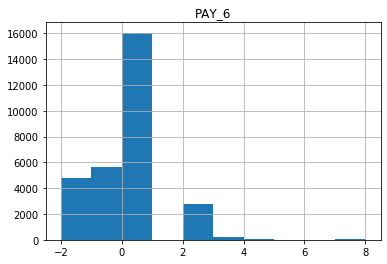

In [9]:
# Basic statistics of the three categorical columns:
df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()
_=df[['PAY_0']].hist()
_=df[['PAY_2']].hist()
_=df[['PAY_3']].hist()
_=df[['PAY_4']].hist()
_=df[['PAY_5']].hist()
_=df[['PAY_6']].hist()

For most of the **PAY_*** categorical variables there is an obvious absence of values equal to 1 for 'payment delay for one month', which is concerning. The months of delay spike up at 2 months, and then decay from there. Additionally, the inclusion of additional categorical values for -2 and 0, which are not outlined in the documentation, make me want to exclude the **PAY_*** features from analysis. 


However, I have had to circle back and include these features as they do somehow give an uplift in model performance. Because the values of -2 and 0 (which were undocumented) seem to somewhat correspond to positive situations (similar to paid duly, -1), I will clean up these features by turning the -2 and -1 values into 0's. 

In [10]:
# Fix the PAY_* columns. Set -2 and -1 values equal to 0
df.replace({'PAY_0': [-2,-1]}, {'PAY_0': 0}, inplace=True)
for i in range(2, 7):
  df.replace({'PAY_' + str(i): [-2,-1]}, {'PAY_' + str(i): 0}, inplace=True)

## Continuous Data Inspection and Cleansing
Inspect the continuous variables, look for anomalies, and filter out bad data. We will look at basic descriptions of the data, as those can show any immediate issues. Variables that we will inspect include:

LIMIT_BAL

BILL_AMT 1-6

PAY_AMT 1-6

In [11]:
# Look at LIMIT_BAL on its own first
df[['LIMIT_BAL']].describe()

,LIMIT_BAL
count,29601.000000
mean,167550.544914
std,129944.020953
min,10000.000000
25%,50000.000000
50%,140000.000000
75%,240000.000000
max,1000000.000000


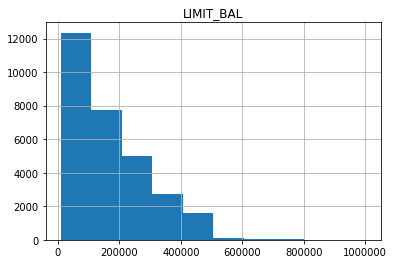

In [12]:
# Look at LIMIT_BAL on its own first
_=df[['LIMIT_BAL']].hist()

**LIMIT_BAL** appears to not have any issue as a feature, but certainly has outliers with customers that have really high credit limits.

Let's examine the **BILL_AMT** features at a high level.

In [13]:
# Look at the BILL_AMT variables
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29601.000000,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000
mean,50957.432012,48942.189554,4.680320e+04,43122.554204,40235.545184,38858.449816
std,73370.242404,70923.985151,6.912389e+04,64196.383913,60699.344884,59519.893043
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3528.000000,2970.000000,2.652000e+03,2329.000000,1780.000000,1278.000000
50%,22259.000000,21050.000000,2.003500e+04,19005.000000,18091.000000,17118.000000
75%,66623.000000,63497.000000,5.983000e+04,54271.000000,50072.000000,49121.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


It is interesting to see that there are large credits being carried by individuals 

Let's see how many people carry a credit through all of the billing cycles. These individuals certainly do not represent the norm, and should likely be filtered out. It would even be an anomaly if someone carried a credit for 6 months and then defaulted. 

To do this, let's add a feature column that indicates if a credit was carried all 6 months, and then filter on that column. 

In [15]:
df['CREDIT_6_MONTHS'] = (df['BILL_AMT1']<0) & (df['BILL_AMT2']<0) & (df['BILL_AMT3']<0) & (df['BILL_AMT4']<0) & (df['BILL_AMT5']<0) & (df['BILL_AMT6']<0)
print('Number of samples with credit all 6 statements:\t{}'.format(np.sum(df['CREDIT_6_MONTHS'])))
default_next_month = np.sum(df[df['CREDIT_6_MONTHS']]['DEFAULT_NEXT_MONTH'])
print('Number of these samples that will default next month:\t{}'.format(default_next_month))
print('Take a look at what these rows of data look like:')
df[df['CREDIT_6_MONTHS'] == True]

Number of samples with credit all 6 statements:	88
Number of these samples that will default next month:	26
Take a look at what these rows of data look like:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,CREDIT_6_MONTHS
ID,,,,,,,,,,,,,,,,,,,,,
110,360000,1,2,1,35,1,0,0,0,0,...,-103,-103,0,0,0,0,0,0,0,True
174,50000,2,1,2,24,1,0,0,0,0,...,-3272,-3272,0,0,0,0,0,0,1,True
217,240000,2,2,1,36,1,0,0,0,0,...,-946,-946,0,0,0,0,0,0,1,True
320,180000,1,2,2,29,1,0,0,0,0,...,-2,-2,0,0,0,0,0,0,0,True
547,220000,2,1,1,41,1,0,0,0,0,...,-65,-200,0,0,0,0,0,0,1,True
1119,140000,2,3,1,54,1,0,0,0,0,...,-150,-150,0,0,0,0,0,0,1,True
1529,120000,1,1,2,38,1,0,0,0,0,...,-1588,-1914,0,0,0,0,0,0,0,True
1796,200000,1,1,2,34,1,0,0,0,0,...,-10213,-11060,0,0,0,0,0,0,0,True
1975,130000,1,1,2,25,1,0,0,0,0,...,-2000,-2000,0,0,0,0,0,0,1,True


I did not expect to see results like these, but unfortunately these samples reside in the data and are not the norm.

For example: There are rows of data where there is the same credit every billing statement (no payments being made), but then the **DEFAULT_NEXT_MONTH** indicator is marked as True. I think it would be best to remove these samples for now, and maybe find out what the situation is with these data points later. 

In [16]:
# Remove samples that had 6 months of statement credits
print('Number of rows before filtering:\t{}'.format(len(df.index)))
df = df[df['CREDIT_6_MONTHS'] == False]
print('Number of rows after filtering: \t{}'.format(len(df.index)))

Number of rows before filtering:	29601
Number of rows after filtering: 	29513


In [17]:
# Remove the CREDIT_6_MONTHS feature since it has no more relevance
df = df.drop('CREDIT_6_MONTHS', axis=1)

Let's examine the **PAY_AMT*** features at a high level.

In [18]:
# Look at the PAY_AMT variables
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29513.000000,2.951300e+04,29513.000000,29513.000000,29513.000000,29513.000000
mean,5666.200793,5.912104e+03,5213.720428,4842.854505,4809.269915,5196.193101
std,16590.118528,2.312139e+04,17604.847634,15732.285985,15264.693586,17681.431559
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.570000e+02,396.000000,300.000000,283.000000,150.000000
50%,2102.000000,2.010000e+03,1804.000000,1500.000000,1501.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.000000,4038.000000,4073.000000,4001.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


Nothing looks to be out of the norm with the payment columns, we will continue with them as they are. 

## Edge Cases
Let's examine some edge cases that may be worth filtering out right now, based on the basic knowledge I have without consulting a Subject Matter Expert (SME).

### All billing ammounts are 0
I have noticed in the data that there are inconsistencies for samples with all billing amounts being 0. Some samples will default the next month, and some won't. 

Number samples with all billing ammounts being 0:	855
Number of these samples that will default next month:	317


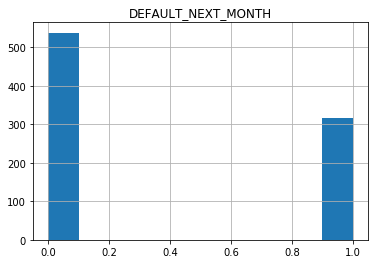

In [19]:
df['ZERO_BILL_6_MONTHS']=(df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].T==0).all()
print('Number samples with all billing ammounts being 0:\t{}'.format(np.sum(df['ZERO_BILL_6_MONTHS'])))
default_next_month = np.sum(df[df['ZERO_BILL_6_MONTHS']]['DEFAULT_NEXT_MONTH'])
print('Number of these samples that will default next month:\t{}'.format(default_next_month))
_=df[df['ZERO_BILL_6_MONTHS']==True][['DEFAULT_NEXT_MONTH']].hist()

In [20]:
# Have a look at some summary stats on this population
df[df['ZERO_BILL_6_MONTHS']==True].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.0,855.0,855.0,855.0,...,855.0,855.0,855.0,855.000000,855.000000,855.0,855.000000,855.000000,855.000000,855.000000
mean,213625.730994,1.638596,1.659649,1.485380,36.906433,0.628070,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.602339,120.584795,0.0,11.695906,189.473684,386.702924,0.370760
std,118631.739999,0.480688,0.741823,0.511653,9.459300,0.483603,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,157.559642,3421.446636,0.0,341.992784,5540.283101,3555.234915,0.483291
min,10000.000000,1.000000,1.000000,1.000000,22.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,130000.000000,1.000000,1.000000,1.000000,29.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,200000.000000,2.000000,2.000000,1.000000,35.000000,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,300000.000000,2.000000,2.000000,2.000000,43.000000,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,710000.000000,2.000000,4.000000,3.000000,75.000000,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3500.000000,100000.000000,0.0,10000.000000,162000.000000,84216.000000,1.000000


I am choosing to remove these sample because they can't be explained, and add unnecessary noise to the data. If given the chance to work with a SME, perhaps we could rationalize a subset of these samples, and/or add more features to be able to do so. 

In [21]:
# Remove samples that had 6 months of zero billing
print('Number of rows before filtering:\t{}'.format(len(df.index)))
df = df[df['ZERO_BILL_6_MONTHS'] == False]
print('Number of rows after filtering: \t{}'.format(len(df.index)))

Number of rows before filtering:	29513
Number of rows after filtering: 	28658


In [22]:
# Remove the ZERO_BILL_6_MONTHS feature since it has no more relevance
df = df.drop('ZERO_BILL_6_MONTHS', axis=1)

## Target Column

Let's take a quick look at our target column **DEFAULT_NEXT_MONTH** to make sure there are no anomalies, and to get an idea of the distribution of the data.

In [23]:
# Quick description of the target variable
df['DEFAULT_NEXT_MONTH'].describe()

count    28658.000000
mean         0.218508
std          0.413241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: DEFAULT_NEXT_MONTH, dtype: float64

Possible target values: [1 0]


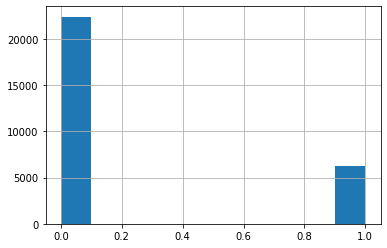

In [24]:
# Look at a histogram of the target variable, and also do a unique on the values to ensure there are no surprises
_=df['DEFAULT_NEXT_MONTH'].hist()
target_vals = df['DEFAULT_NEXT_MONTH'].unique()
print('Possible target values: ' + str(target_vals))

There appear to be no surprises in the target value, but we do have an imbalance in the data that we need to be cognizant of when splitting the data. At present, the likelihood of default next month is about 22% for the total population. This seems high if this were to happen every month.

# Feature Engineering
Let's explore some possible features we can engineer to help our models

## Pay vs Bill Differences
It appears that **PAY_AMT*** and **BILL_AMT*** are offset by a month, which makes sense. A credit card can close in one month, and be paid in the next. A good indicator of this alignment can be seen by taking a difference between **BILL_AMT*** and **PAY_AMT*** aligned vs offset by a month. There are a large number of people that pay their card off each month, and this helps us verify that there is indeed an offset. 

In [25]:
# Look at aligned BILL_AMT* vs PAY_AMT*
pay_bill_aligned = pd.DataFrame()
for i in range(1, 7):
  pay_bill_aligned['MONTH' + str(i)] = df['PAY_AMT' + str(i)] - df['BILL_AMT' + str(i)]

print("Number of occurances where the billed amount equaled the paid ammount\n" +
      "when the months are ALIGNED:")  
print((pay_bill_aligned == 0).sum().to_string())

Number of occurances where the billed amount equaled the paid ammount
when the months are ALIGNED:
MONTH1    1264
MONTH2    1617
MONTH3    1991
MONTH4    2217
MONTH5    2442
MONTH6    2969


In [26]:
# Look at offset BILL_AMT* vs PAY_AMT*
pay_bill_aligned = pd.DataFrame()
for i in range(2, 7):
  pay_bill_aligned['MONTH' + str(i)] = df['PAY_AMT' + str(i-1)] - df['BILL_AMT' + str(i)]

print("Number of occurances where the billed amount equaled the paid ammount\n" +
      "when the months are OFFSET:")  
print((pay_bill_aligned == 0).sum().to_string())

Number of occurances where the billed amount equaled the paid ammount
when the months are OFFSET:
MONTH2    5599
MONTH3    5952
MONTH4    6275
MONTH5    6843
MONTH6    7579


Seeing that the **PAY_AMT*** and **BILL_AMT*** are in more agreement when offset by a month, we can use this to create 5 new features. These features will be labeled **DIFF_AMT*** (2-6).

In [27]:
for i in range(1, 6):
  df['DIFF_AMT' + str(i)] = df['PAY_AMT' + str(i)] - df['BILL_AMT' + str(i+1)]

In [28]:
# Let's just have a quick look at what one of these features looks like at a 
# high level
df['DIFF_AMT2'].describe()

count    2.865800e+04
mean    -4.226237e+04
std      6.617716e+04
min     -6.766430e+05
25%     -5.559925e+04
50%     -1.711650e+04
75%      0.000000e+00
max      1.181069e+06
Name: DIFF_AMT2, dtype: float64

In [29]:
# Let's inspect some extreme cases
df[df['DIFF_AMT2'] > 1e5]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,DIFF_AMT1,DIFF_AMT2,DIFF_AMT3,DIFF_AMT4,DIFF_AMT5
ID,,,,,,,,,,,,,,,,,,,,,
1387,360000,1,1,2,36,0,0,0,0,0,...,100000,3000,3000,5000,0,1695,101786,-68014,-13209,-15918
6151,300000,2,3,2,39,1,0,0,0,0,...,6822,49,15000,12000,1,7693,339732,636,-67,571
11012,220000,1,2,2,35,1,0,0,0,0,...,7308,0,2912,0,0,0,138553,-38869,-3308,0
14180,150000,1,2,2,23,0,0,0,0,0,...,823,80000,3684,4500,1,-144474,112526,-7350,-7500,-86047
14514,460000,2,1,1,43,0,0,0,0,0,...,80017,31017,27,38700,0,-256215,270842,-217022,-227039,-188056
14991,160000,1,3,2,27,1,2,0,0,0,...,1800,90000,3300,3400,1,-34775,108775,-13876,-9436,-87627
15130,150000,1,2,2,52,0,0,0,0,0,...,136320,5001,5000,5001,0,2796,137783,6473,-126968,-129515
17205,70000,1,2,2,29,0,0,0,0,0,...,10000,15000,10000,20000,0,17810,100699,2538,5610,4817
18116,170000,1,1,2,48,0,0,0,0,0,...,332809,6000,6000,6100,0,-4853,157264,165840,-158040,-160416


It is interesting to see that there are values this high. Maybe people take a proactive approach and pay on their cards before the billing cycle comes out, especially in the upper echelon of card holders with high balances (are these business credit cards possibly?). This would result in a low bill and show a high payment, but only if they do that consistently. There is such a wide range on this feature, and I will need to normalize it if I include it in my models. One way around this is to express this as a portion, rather than a difference, which I will do with the next feature. 

## Pay vs Bill Portions

Let's also create a version of this feature that expresses the payment as a portion of the billed amount so that it scales. This can really help overcome potential outliers due to the wide range of credit limits.

In [30]:
# Need to create a function to handle this calculation gracefuly, and be able to
# apply it to each row. Accept an input indicating the iterator for the month so
# that we can perform out calculations on the various columns dynamically.
def func(row, i):
    if row['BILL_AMT' + str(i+1)] <= 0:
        # Case where we have a 0 balance, or even a credit. Just mark it as 0.
        return 0
    else:
        return row['PAY_AMT' + str(i)]/(row['BILL_AMT' + str(i+1)])

# Just like with the differences, apply this over the range of months.
for i in range(1, 6):
  df['PAY_PORTION' + str(i)] = df.apply(func, axis=1, i=i)

In [31]:
# Let's just have a quick look at what one of these features looks like at a 
# high level
df['PAY_PORTION2'].describe()

count    28658.000000
mean         0.675158
std         39.576482
min          0.000000
25%          0.037454
50%          0.064825
75%          0.646865
max       5001.000000
Name: PAY_PORTION2, dtype: float64

In [32]:
# Let's inspect some extreme cases
df[df['PAY_PORTION1'] > 20]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,DIFF_AMT1,DIFF_AMT2,DIFF_AMT3,DIFF_AMT4,DIFF_AMT5,PAY_PORTION1,PAY_PORTION2,PAY_PORTION3,PAY_PORTION4,PAY_PORTION5
ID,,,,,,,,,,,,,,,,,,,,,
3413,160000,2,2,2,50,0,0,0,0,0,...,13330,13330,13330,13330,0,4444.333333,4444.333333,4444.333333,1.999775,0.000000
4636,50000,1,3,2,28,1,0,0,0,0,...,9901,0,-4,0,0,101.010101,1.000000,0.983936,1.000000,1.000000
10564,260000,1,1,2,36,0,0,0,0,0,...,9573,73,73,73,73,23.419204,0.000000,0.000000,0.000000,0.000000
13187,750000,2,1,2,28,1,0,0,0,0,...,240345,0,-391503,-389993,8507,25.893320,1.000000,0.020000,0.027432,1.020775
14454,330000,2,1,2,28,1,0,2,2,2,...,493,-11,-11,-11,-11,45.818182,0.000000,0.000000,0.000000,0.000000
14455,150000,2,3,2,40,0,0,0,0,0,...,30680,0,-390,0,-382,21.828242,1.000000,0.000000,1.000000,0.000000
15362,470000,2,2,2,36,0,0,0,0,0,...,1871,0,0,-157,0,22.022472,0.000000,1.000000,0.000000,1.000000
21349,70000,1,1,1,67,1,0,0,2,2,...,10000,10000,-2,-2,-2,26.000000,5001.000000,0.000000,0.000000,0.000000
25648,130000,2,2,1,47,0,0,0,0,0,...,2971,405,-30,2018,2452,103.448276,1.156069,0.970874,0.000000,0.000000


I am not too shocked to see a max value as high as this one. Maybe people take a proactive approach and pay on their cards before the billing cycle comes out. This would result in a low bill and show a high payment, but only if they do that consistently. I'm not sure if I need to eliminate these samples with the high values right now, or if I can keep them because they represent a small fraction of the samples in the data. Since most values reside between 0 and 1, I don't think it's going to be absolutely necessary to scale this feature. 

## Credit Utilization
One thing that I think might be a good feature to calculate is credit utilization. This is something we all see on our credit reports, and is likely included because it has a potential to signal default in the future. The great thing about this feature is it will most likely be in a range suitable for models.  

In [33]:
for i in range(1, 7):
  df['CREDIT_UTIL' + str(i)] = df['BILL_AMT' + str(i)]/df['LIMIT_BAL']
  
# Let's just have a quick look at what one of these features looks like at a 
# high level
df['CREDIT_UTIL1'].describe()

count    28658.000000
mean         0.436254
std          0.409731
min         -0.619892
25%          0.029454
50%          0.345613
75%          0.840752
max          6.455300
Name: CREDIT_UTIL1, dtype: float64

In [34]:
# How many cases are there where people go above their credit limit in the most recent month?
num_high_credit_useage = np.sum(df['CREDIT_UTIL1'] > 1)
print('Number of samples with current bills larger than their credit ' + 
      'limit:\t{}'.format(num_high_credit_useage))

# What portion of the remaining population do these people represent?
num_samples = len(df)
print('The portion of high credit utilization samples from the total ' + 
      'set is:\t{}'.format(num_high_credit_useage/num_samples))

# How many people with credit utilization greater than 1 will default in the 
# next month?
high_util_default = (df['CREDIT_UTIL1'] > 1) & (df['DEFAULT_NEXT_MONTH'] == 1)
num_high_util_default = np.sum(high_util_default)
print('Number of those high credit utilization samples that will ' + 
      'default:\t{}'.format(num_high_util_default))

# What portion is that?
print('The portion of high credit utilization samples that will ' + 
      'default is:\t{}'.format(num_high_util_default/num_high_credit_useage))

Number of samples with current bills larger than their credit limit:	2069
The portion of high credit utilization samples from the total set is:	0.07219624537650918
Number of those high credit utilization samples that will default:	630
The portion of high credit utilization samples that will default is:	0.3044949250845819


Those with high credit utilization over their credit limit represent about 7% of the total population, and they have a likelihood of default of about 30%. This subset of the population has a close to 40% greater chance of default next month than the overall population.

## Scaled Payment
Similar to credit utilization, I think it might be useful to scale the **PAY_AMT*** features by **LIMIT_BAL**. When the feature is ultimately normalized, this engineered feature should better reflect the impact of the payments.

In [35]:
for i in range(1, 7):
  df['SCALED_PAY_AMT' + str(i)] = df['PAY_AMT' + str(i)]/df['LIMIT_BAL']
  
# Let's just have a quick look at what one of these features looks like at a 
# high level
df['SCALED_PAY_AMT1'].describe()

count    28658.000000
mean         0.046482
std          0.101515
min          0.000000
25%          0.006436
50%          0.026200
75%          0.046007
max          2.604100
Name: SCALED_PAY_AMT1, dtype: float64

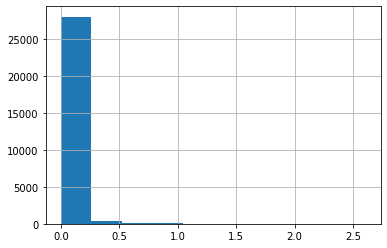

In [36]:
_=df['SCALED_PAY_AMT1'].hist()

There appear to be a few outliers where people have paid more than their **LIMIT_BAL**, but these are rare. This may be a useful feature for our models. 

# Additional Data Visualization
Let's further explore the data through additional visualizations.

An easy visualization to produce is pairplots of a select subset of the features. I am not including **BILL_AMT***, **PAY_AMT***, and most of **DIFF_AMT*** as these are essentially timeseries data for different subjects at different points in their economic cycles. Sure, there will be some correlation between offset months of **BILL_AMT*** and **PAY_AMT***, but we have already seen this and is due to people who actually pay off their card. I am only including the 2 most recent **DIFF_AMT*** features, as I wonder if we can see any trend or correlation that may give any indication of default. In the pair plots, I have given assigned hues to the plots and histograms based on **DEFAULT_NEXT_MONTH**. Orange indicates samples that will default the next month, and blue indicates samples that will NOT default the next month.

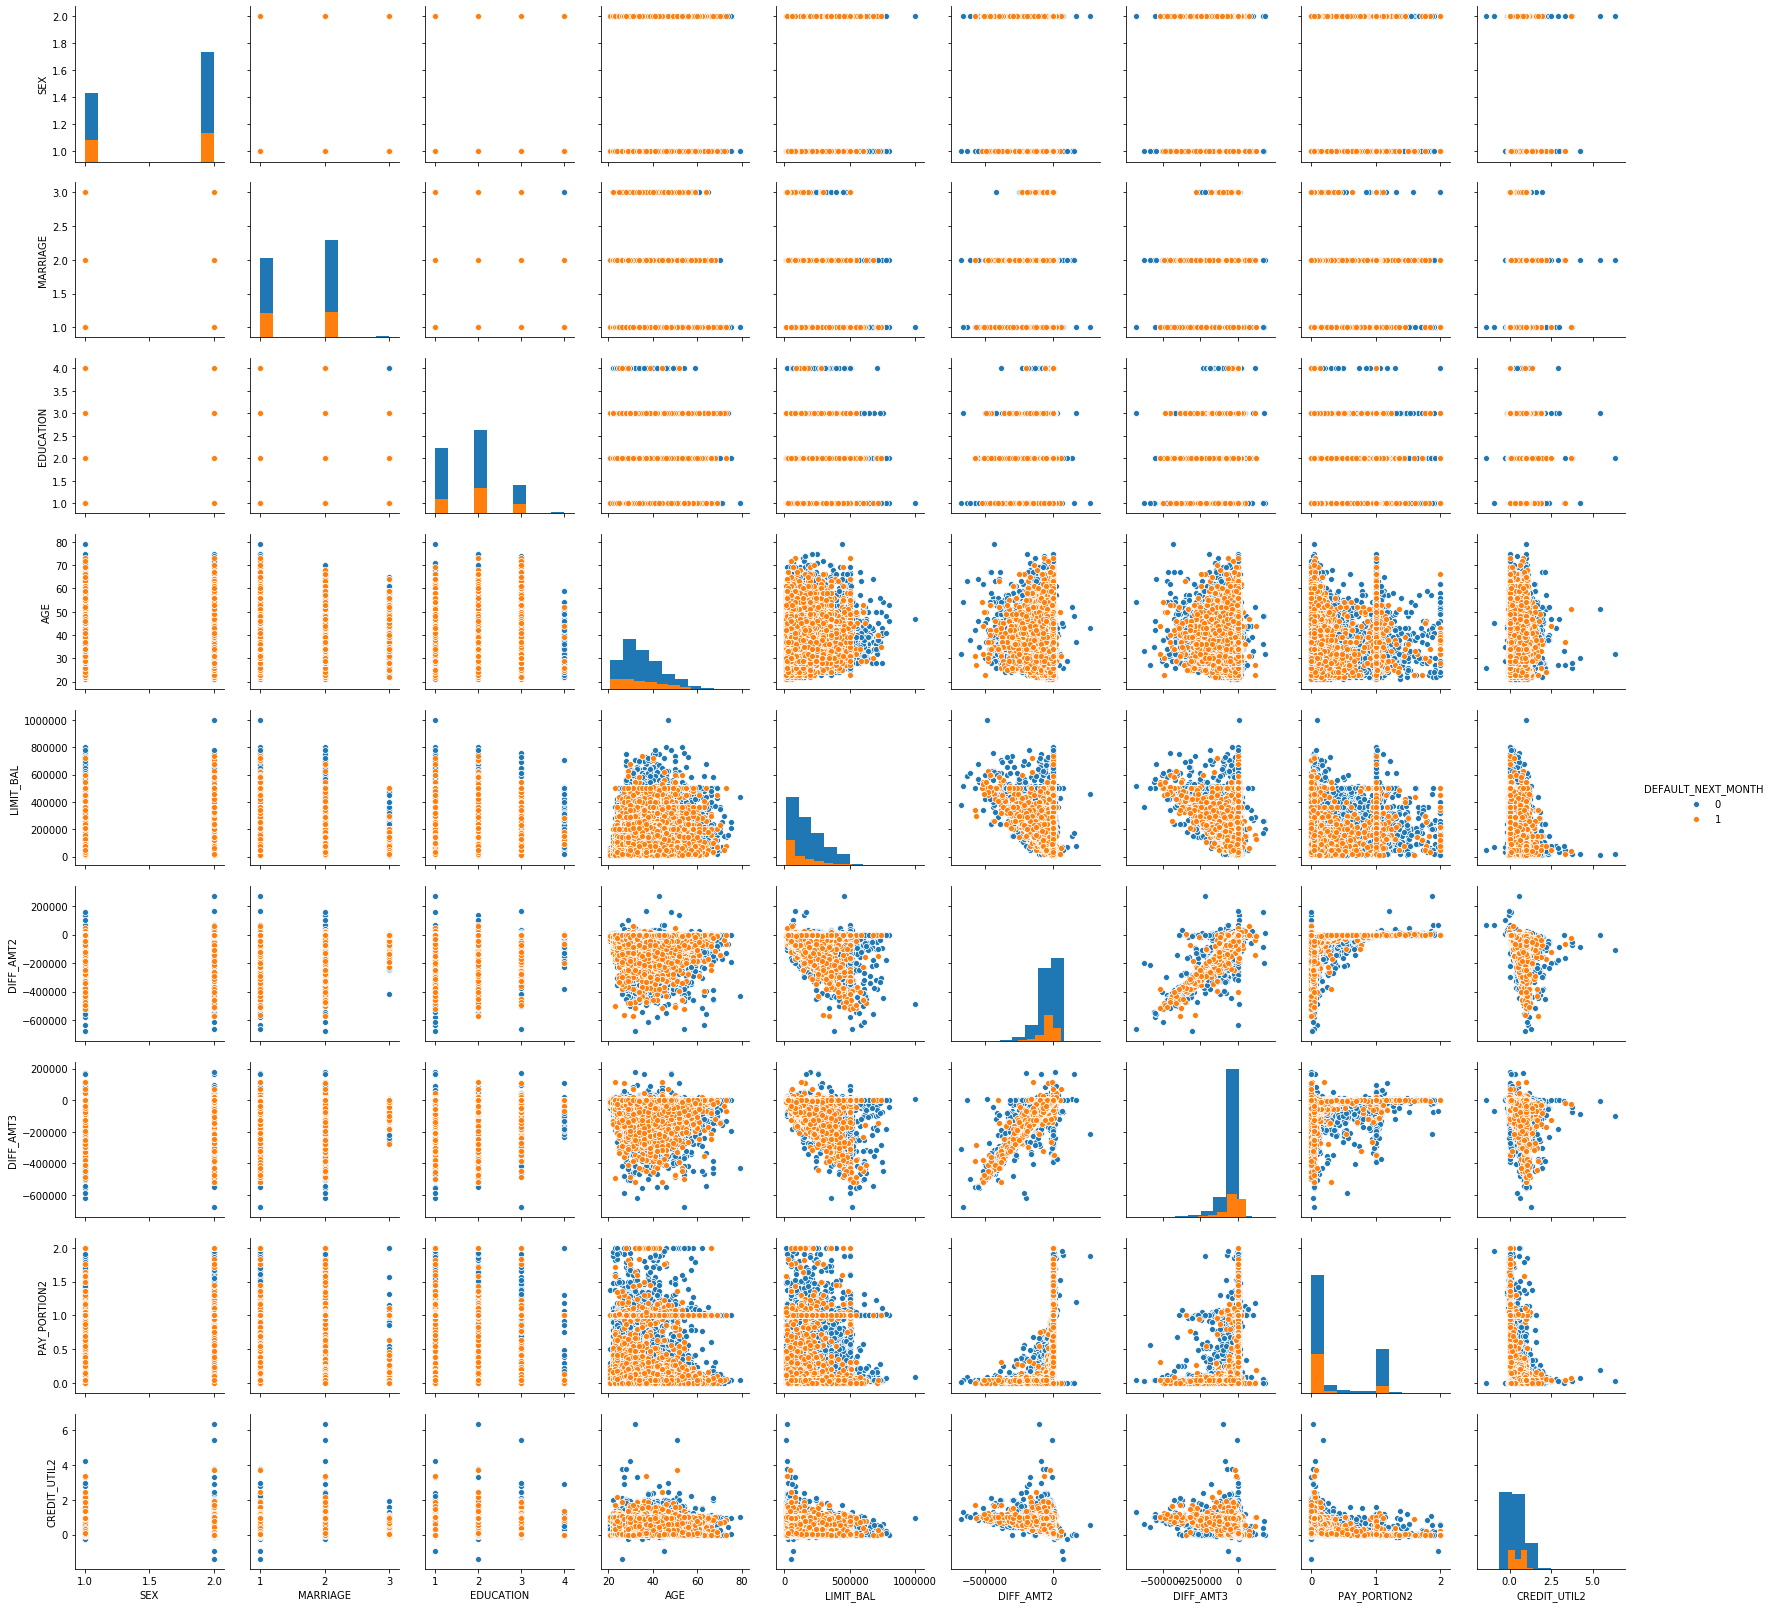

In [37]:
# Let's limit the data to where PAY_PORTION2 is <=2 for just this visualization 
# so that we remove the highly skewed outliers. This should help us potentialy
# see if there are any feature pairs (involving PAY_PORTION2) that can 
# potentialy predict default.
sns.pairplot(df[df['PAY_PORTION2'] <=2],hue='DEFAULT_NEXT_MONTH',
                vars=['SEX','MARRIAGE','EDUCATION','AGE', 'LIMIT_BAL',
                      'DIFF_AMT2','DIFF_AMT3', 'PAY_PORTION2', 'CREDIT_UTIL2'],
                diag_kind='hist')

# *Takeaways from Data Visualization/Exploration *
Here is a summary of takeaways from visualizing and exploring the data:

*   There needed to be a lot of pre-processing done to the data to get around unexplainable values. For the sake of this exercise, the values were removed rather than rectified. This was done for **EDUCATION** and **MARRIAGE**.
*   For most of the  **PAY_*** categorical variables there is an obvious absence of values equal to 1 for 'payment delay for one month', which is concerning. The months of delay spike up at 2 months, and then decay from there. Additionally, the inclusion of additional categorical values for -2 and 0, which are not outlined in the documentation, lead me to ***initially*** exclude the **PAY_*** features from analysis. I did have come back and include these features as they do somehow give an uplift in model performance. Because the values of -2 and 0 (which were undocumented) seem to somewhat correspond to positive situations (similar to paid duly, -1), I cleaned up these features by turning the -2 and -1 values into 0's.  
*   The **LIMIT_BAL** feature appears to have a wide range, going all the way up to 10^6. However, if you account for currency conversion from New Taiwan Dollar to USD in 2009, the range really only goes to 30K USD. It doesn't matter as this feature will be normalized.
*   Examining the **BILL_AMT*** features show that there are some people carrying large CREDITS on their credit cards. There were  88 cases of people carrying credits for all 6 months of observation. Of those 88 samples, 26 samples still somehow defaulted the next month, which makes no sense. Since these 88 samples are a small subset and are outliers, they were removed from the data.
*   A set of edge cases I saw were people that had 0 billing for all 6 months of tracked activity. There were 855 samples that had 0 bills for 6 months, and of those 317 still managed to default the next month (roughly 37%). There is also very little payment activity with these samples. Since they have little information to offer, and add noise to the response variable, they were removed.
*   Of the remaining samples, 22% will default the next month. This value seems a bit high, but perhaps there's more information to be understood about it. We will need to keep this in mind when splitting the data for testing and validation, as the data is unbalanced.
*   The **PAY_AMT*** and **BILL_AMT*** features are offset by 1 month, which makes sense when you take into account how long people have to pay their bills. Ex: **PAY_AMT1** would frequently equal **BILL_AMT2**, **PAY_AMT2** would frequently equal **BILL_AMT3**, and so on. This is made evident by people paying their card off each month.
*   There are samples that have **BILL_AMT*** greater than **LIMIT_BAL**.
*   Credit utilization (**BILL_AMT*/LIMIT_BAL**) may be a good engineered feature to help indicate who may default in the next month. Samples with credit utilization is greater than 1 (as pointed out in the prior point) are 50% more likely to default the next month than the general population.
*   In the feature pairwise plots and feature histograms that were colors based on **DEFAULT_NEXT_MONTH**, no single or two-feature combination stood out to me as a clear indicator of potential default. 
*   At the end of all the data cleaning there are still 28658 samples remaining, which is ample.





# *Data Pre-Processing Steps *
There are a few last pre-processing steps I need to take:

*   Normalize some features from 0 to 1 when they cover a wide range
*   Create one-hot-encoded features from some of the categorical features. For example, **EDUCATION** might yield undesirable results if it were treated as a continuous variable for regression.
*   Split the data into train and test portions. We will do a 70/30 split since there is an ample amount of data available. 



For the record we have the following columns to work with:

In [38]:
print(df.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEFAULT_NEXT_MONTH', 'DIFF_AMT1', 'DIFF_AMT2', 'DIFF_AMT3',
       'DIFF_AMT4', 'DIFF_AMT5', 'PAY_PORTION1', 'PAY_PORTION2',
       'PAY_PORTION3', 'PAY_PORTION4', 'PAY_PORTION5', 'CREDIT_UTIL1',
       'CREDIT_UTIL2', 'CREDIT_UTIL3', 'CREDIT_UTIL4', 'CREDIT_UTIL5',
       'CREDIT_UTIL6', 'SCALED_PAY_AMT1', 'SCALED_PAY_AMT2', 'SCALED_PAY_AMT3',
       'SCALED_PAY_AMT4', 'SCALED_PAY_AMT5', 'SCALED_PAY_AMT6'],
      dtype='object')


## One-Hot-Encoded Features
We will encode the following features with one-hot encoding:
*   **EDUCATION**
*   **MARRIAGE**

We will also subtract 1 from the **SEX** feature, so that it lies in the range [0,1], rather than [1,2].



In [39]:
# One-hot encoding of the MARRIAGE feature
marriage_one_hot = pd.get_dummies(df['MARRIAGE'],prefix='MARRIAGE')
df = df.join(marriage_one_hot)

# One-hot encoding of the EDUCATION feature
education_one_hot = pd.get_dummies(df['EDUCATION'],prefix='EDUCATION')
df = df.join(education_one_hot)

# Correct the SEX feature
df['SEX'] = df['SEX'] - 1


# Remove the old MARRIAGE and EDUCATION features
df = df.drop('MARRIAGE', axis=1)
df = df.drop('EDUCATION', axis=1)

In [40]:
# Capture the column names of the features
one_hot_cols = ['SEX'] + marriage_one_hot.columns.values.tolist() + \
               education_one_hot.columns.values.tolist()

## Scaled Features
We will normalize the following features:

*   **LIMIT_BAL**
*   **AGE**
*   **CREDIT_UTIL*** (Use this instead of **BILL_AMT*** since it incorporates **LIMIT_BAL**)
*   **PAY_PORTION***
*   **SCALED_PAY_AMT***



In [41]:
# Variables to be scaled by a MinMaxScaler:
min_max_cols = ['LIMIT_BAL', 'AGE', 'PAY_PORTION1', 'PAY_PORTION2', 
                'PAY_PORTION3', 'PAY_PORTION4', 'PAY_PORTION5', 
               'SCALED_PAY_AMT1', 'SCALED_PAY_AMT2', 'SCALED_PAY_AMT3', 
               'SCALED_PAY_AMT4', 'SCALED_PAY_AMT5', 'SCALED_PAY_AMT6']

# Perform min-max scaling
min_max_scaler = preprocessing.MinMaxScaler()
df[min_max_cols] = min_max_scaler.fit_transform(df[min_max_cols].values)

# Quick eval of the scaled features
df[min_max_cols].describe()



,LIMIT_BAL,AGE,PAY_PORTION1,PAY_PORTION2,PAY_PORTION3,PAY_PORTION4,PAY_PORTION5,SCALED_PAY_AMT1,SCALED_PAY_AMT2,SCALED_PAY_AMT3,SCALED_PAY_AMT4,SCALED_PAY_AMT5,SCALED_PAY_AMT6
count,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000
mean,0.157609,0.248620,0.000111,0.000135,0.000106,0.002402,0.000531,0.017849,0.003579,0.015048,0.011775,0.015939,0.013672
std,0.131352,0.158737,0.005912,0.007914,0.005913,0.009299,0.007498,0.038983,0.010032,0.036145,0.031814,0.039931,0.036486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040404,0.120690,0.000009,0.000007,0.000007,0.000236,0.000048,0.002471,0.000469,0.001595,0.000920,0.001141,0.000666
50%,0.131313,0.224138,0.000015,0.000013,0.000011,0.000333,0.000065,0.010061,0.001947,0.007649,0.005386,0.007440,0.005925
75%,0.232323,0.344828,0.000150,0.000129,0.000100,0.002920,0.000685,0.017667,0.003470,0.014478,0.010667,0.014932,0.012508
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# CREDIT_UTIL* will only be scaled by its max values, as there is some 
# information value to possibly be had when the value goes negative. 
max_abs_cols = ['CREDIT_UTIL' + str(i) for i in range(1,7)]
max_abs_scaler = preprocessing.MaxAbsScaler()
df[max_abs_cols] = max_abs_scaler.fit_transform(df[max_abs_cols].values)

# Quick eval of the scaled features
df[max_abs_cols].describe()

,CREDIT_UTIL1,CREDIT_UTIL2,CREDIT_UTIL3,CREDIT_UTIL4,CREDIT_UTIL5,CREDIT_UTIL6
count,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000,28658.000000
mean,0.067581,0.066375,0.037822,0.072042,0.069719,0.084855
std,0.063472,0.063182,0.037043,0.071561,0.071027,0.089033
min,-0.096028,-0.218720,-0.095906,-0.267057,-0.177640,-0.388498
25%,0.004563,0.003923,0.002086,0.003984,0.003242,0.003052
50%,0.053539,0.051422,0.028191,0.052233,0.048367,0.053867
75%,0.130242,0.128180,0.072137,0.132511,0.124190,0.152834
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train and Test Split
Let's split the data into train and test components (70/30). We will shuffle the samples, and stratify on the target column (**DEFAULT_NEXT MONTH**) so that we maintain the same portion of defaults in both sets of data.

In [43]:
target_col = 'DEFAULT_NEXT_MONTH' 
df_train, df_test = model_selection.train_test_split(df,test_size=0.3, 
                                                     shuffle=True,
                                                     stratify=df[target_col].values)

# Compile the list of all of our features
feature_cols = one_hot_cols + min_max_cols + max_abs_cols
feature_cols += ['PAY_0']
feature_cols += ['PAY_' + str(i) for i in range(2,7)]

feature_cols

['SEX',
 'MARRIAGE_1',
 'MARRIAGE_2',
 'MARRIAGE_3',
 'EDUCATION_1',
 'EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_4',
 'LIMIT_BAL',
 'AGE',
 'PAY_PORTION1',
 'PAY_PORTION2',
 'PAY_PORTION3',
 'PAY_PORTION4',
 'PAY_PORTION5',
 'SCALED_PAY_AMT1',
 'SCALED_PAY_AMT2',
 'SCALED_PAY_AMT3',
 'SCALED_PAY_AMT4',
 'SCALED_PAY_AMT5',
 'SCALED_PAY_AMT6',
 'CREDIT_UTIL1',
 'CREDIT_UTIL2',
 'CREDIT_UTIL3',
 'CREDIT_UTIL4',
 'CREDIT_UTIL5',
 'CREDIT_UTIL6',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

# *Model Exploration *

In this section we will explore different models that can be used to predict default the next month. In the interest of time and simplicity I will only use classification models from the sklearn package, as they follow the same design pattern (init, fit, predict) to train and use a model. Given this common pattern, I can create a function to train each model and benefit from code reusability. This will allow me flexibility in the future if I decide to add more metrics, change the number of folds I want to use during cross validation, etc. 

The following models will be evaluated:


1.   Random Forest
2.   AdaBoost (Adaptive Boosting)
3.   Gradient Boosting Classification Tree
4.   Logistic Regression
5.   Bagging Classifier
6.   K Nearest Neighbors


I have chosen three metrics to evaluate the models: accuracy, Area Under the Curve (AUC), and F1 score. Accuracy is the most basic of the metrics, but will give us a good overall sense for how we are doing. Additionally, error rate was the metric used in the original 2009 paper that this data comes from, which is the complement of accuracy. This will allow us to see if our results can at least be in the same ball park as the original paper. 

With regards to AUC, I typically like to see the AUC metric for a binary classifier above 0.9, which would indicate that the model is better able to distinguish positive and negative samples. However, given what I have seen in the exploratory portion of this exercise, I have a feeling that we should not expect a high AUC. 

I include F1 score in the evaluation because accuracy can be largely contributed to here by the high number of True Negatives (business as usual, no default), and I don't know the business costs of a False Negative (Recall) or a False Positive (Precision) in this case. F1 score will strike a balance between Precision and Recall for us, and give us an additional indication of how we are doing in terms of predicting default or not when comparing models. 

Finally, I add an additional metric as an objective score for choosing which model to go forward with. Since all three metrics range from 0 to 1, and have the potential to each be used on their own as the default metric, this objective score will just be the average of all three metrics.

Throughout the exploration process I did do some manual tuning of the models to try to improve performance. If given more time, I would automate this process. 

In [44]:
# Portion out the training data into X and y components from the dataframe, 
# retaining just the selected features for the X variable, and the target column
# for the y variable. 
X_train = df_train[feature_cols].values
y_train = df_train[target_col].values

# Set the number of folds we want to use.
n_folds = 10

# Prepare a dictionary to store our results
results = dict()

In [45]:
# Leverage code reuse, and the fact that all models follow the same design 
# pattern, by implementing a common training and cross validation function.
def train_cv(X, y, n_folds, clf):
  """
  Method to train and cross validate a model. 
  X: 2D ndarray with the training data along rows, and features along columns.
  y: 1D np array with the target values for the samples in X
  n_folds: The number of folds for cross validation.
  clf: The instantiated classifier object.
  returns: average accuracy, average AUC, and average F1 score across the folds.
  """
  
  # Prepare the stratified k-folds object
  skf = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True)
  
  # Prepare the arrays to store intermediate results
  accuracies = []
  aucs = []
  f1s = []
  
  # Iterate over all the folds
  for train_index, val_index in skf.split(X, y):
    # Get the data for the fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Train the model, and then predict the validation data
    clf.fit(X_train_fold, y_train_fold)
    y_pred_fold = clf.predict(X_val_fold)

    # Calculate accuracy
    acc = metrics.accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(acc)

    # Calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_val_fold, y_pred_fold, 
                                             pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)

    # Calculate F1 score
    f1 = metrics.f1_score(y_val_fold, y_pred_fold, pos_label=1, 
                          average='binary')
    f1s.append(f1)
  
  # Return the metric averages and objective score in a dictionary
  acc, auc, f1 = np.mean(accuracies), np.mean(aucs), np.mean(f1s)
  score = acc/3 + auc/3 + f1/3
  return {'Accuracy':acc, 'AUC':auc, 'F1 Score':f1, 'Score':score}

## Random Forest

In [53]:
# Prepare the model
clf = RandomForestClassifier(n_estimators=300, max_depth=9, max_features=7)

# Train and store results
results['Random Forest'] = train_cv(X_train, y_train, n_folds, clf)

## AdaBoost

In [47]:
# Prepare the model
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)

# Train and store results
results['AdaBoost'] = train_cv(X_train, y_train, n_folds, clf)

## Gradient Boosting Classification Tree

In [48]:
# Prepare the model
clf = GradientBoostingClassifier(n_estimators=50, max_depth=4)

# Train and store results
results['Gradiet Boosting'] = train_cv(X_train, y_train, n_folds, clf)

## Logistics Regression

In [49]:
# Prepare the model
clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Train and store results
results['Logistic Regression'] = train_cv(X_train, y_train, n_folds, clf)

## Bagging Classifier

In [50]:
# Prepare the model
clf = BaggingClassifier(n_estimators=100)

# Train and store results
results['Bagging Classifier'] = train_cv(X_train, y_train, n_folds, clf)

## K Nearest Neighbors

In [51]:
# Prepare the model
clf = KNeighborsClassifier(n_neighbors=40)

# Train and store results
results['KNN'] = train_cv(X_train, y_train, n_folds, clf)

## Model Exploration Results 
Collect all the results in to a table, and compare them to determine which model we want to go forward with. 

In [54]:
# Create the results data frame, transpose it, and print it
results_df = pd.DataFrame(results).T
results_df

,AUC,Accuracy,F1 Score,Score
Random Forest,0.663983,0.825474,0.485516,0.658325
AdaBoost,0.646958,0.820191,0.451635,0.639595
Gradiet Boosting,0.665197,0.824426,0.487559,0.659061
Logistic Regression,0.647321,0.821535,0.452520,0.640459
Bagging Classifier,0.659272,0.819143,0.475502,0.651306
KNN,0.657203,0.821436,0.471808,0.650149


We can produce an objective score that helps us identify which model to move forward with. For the sake of simplicity in this exercise, I am chosing to just weight all three metrics evenly, and take the average of them all. This will produce a score that can help us objectively pick our final model. 

Given the results table above, and the scores given to the models, I could reasonably proceed with either Random Forest or Gradient Boosting. Of the two, I am more familier with **Random Forest**, so I will proceed with using that for our final model. 

# *Fit Selected Model to Analytics Ready Dataset *
Rather than just fitting the selected model to the training dataset, let's first try to hyperparameter tune it to ensure we are going forward with the best set of parameters. We will be using randomized search as this should cover a larger amount of the hyperparameter space in a shorter amount of time than grid search. 

In [55]:
# Build the Random Forest classifier
clf = RandomForestClassifier()


# Specify the hyperparameters and their distributions to draw from in the search
param_dist = {'n_estimators': sp_randint(20, 400), 
              'max_depth': [3,4,5,6,7,8,9,10,None],
              'max_features': sp_randint(1, 11),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'class_weight': ['balanced', None],
              'criterion': ['gini', 'entropy']}

# Run the random search for 100 iterations.
n_iter_search = 100
X = df_train[feature_cols].values
y = df_train[target_col].values
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, iid=False,
                                   scoring=['accuracy', 'roc_auc', 'f1'],
                                   n_jobs=2,
                                   refit=False)
_=random_search.fit(X, y)



In [56]:
# Find the model with the best average score across all 3 of our metrics
mean_accuracy = random_search.cv_results_['mean_test_accuracy']
mean_f1 = random_search.cv_results_['mean_test_f1']
mean_auc = random_search.cv_results_['mean_test_roc_auc']
mean_score = mean_accuracy/3 + mean_f1/3 + mean_auc/3
idx_best_model = np.argmax(mean_score)

# Get the parameters for this model
params = random_search.cv_results_['params'][idx_best_model]
print("Best model parameters:")
print(params)

# Instantiate the model with the tuned parameters, and train it on all the 
# training data available now.
best_model = RandomForestClassifier(**params)
_=best_model.fit(X_train, y_train)

Best model parameters:
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 376}


# *Evaluate Model Performance on Testing Dataset *
Now that we have the final version of the model trained on all of the training data, let's evaluate it on the test data that we have held out since the beginning. To be consistent, I will continue to evaluate accuracy, AUC, F1 score, and the average of all three of the preceding metrics. While I am most concerned with just the three individual metrics, the averaged score will give me a sense for how the tuned model compares to all the models that we previously evaluated.

In [57]:
# Evaluate the model with test data
X_test = df_test[feature_cols].values
y_test = df_test[target_col].values
y_pred = best_model.predict(X_test)

# Calculate accuracy
acc = metrics.accuracy_score(y_test, y_pred)

# Calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

# Calculate F1 score
f1 = metrics.f1_score(y_test, y_pred, pos_label=1, average='binary')

# For the sake of comparison with all the previou models, let's calcualte the 
# average of all three metrics
score = acc/3 + auc/3 + f1/3

print('Accuracy with test data:\t{}'.format(acc))
print('AUC with test data:\t\t{}'.format(auc))
print('F1 score with test data:\t{}'.format(f1))
print('Overall score with test data:\t{}'.format(score))

Accuracy with test data:	0.7986741102581996
AUC with test data:		0.7071054093381853
F1 score with test data:	0.5416997617156473
Overall score with test data:	0.6824930937706775


Overall, the tuned model had a worse accuracy than the initial screened Random Forest model, but actually improved on AUC and F1 score. This tells me that the tuned model was likely better able to discriminate the positive and negative samples, but ended up producing more false positives in the end (which decreased the overall accuracy). The test error rate for this model is about 0.2, which is in range of the values seen in the original 2009 paper (0.16 to 0.26).

# *What other options would I have considered if I had additional time? * 

If I had more time, I would have really tried to dive down into the data more. Ideally, it would be nice to talk to whoever collected the data or go to the original source just to understand some of the nuances, including:

*   The undocumented values in the **PAY_*** features. I think there was more to the -2 and 0 values. 
*   The undocumented values in the **MARIAGE** and **EDUCATION** features. 
*   Why was there a lack of values equal to 1 in a majority of the **PAY_*** features? 
*   Instead of just monthly billing amount, which can be offset by early payments, is monthly spending amount available?
*   Were the minimum payment amount available?

I would have also spent more time engineering more features. I think there may be value in engineering features that mimic the **PAY_*** features, as I am not too sure about how those features were constructed.

In regards to the modeling, I would have definitely spent more time around model selection. All of the models I explored were very quickly and simply tuned to try to get a decent performance. Given more time and computational resources, I would have done a random hyperparameter search for each possible model to try to find the overall best model out of all the candidates. I could have also let the random hyperparameter search process for the selected model run for many more iterations.

All the models investigated were also all part of the sci-kit learn package. As stated above, this was done for speed and simplicity. While I like the package, it is not the only option out there. Given more time we could also write wide and deep models in Tensorflow, or even toy with the idea of using recurrent neural networks (we would also need more historical data). 

Lastly, given the large number of samples, this problem could possibly be approached using a Bayesian technique. I think there certainly would need to be an improvement in the data quality, as well as an increase the lookback time to capture previous defaults of other samples. If these improvements could be done, a Bayesian method could be worth spending time on. 
